# Imports & Session Utils

In [157]:
import numpy as np
from scipy.stats import norm
from enum import Enum
import typing as tp
from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from os import listdir
import os
import pandas as pd
import sys

saves = listdir("saves/models/")
saves = list(map(lambda x: int(x.split(".")[0]), saves))

SESSION = str(max(saves) + 1)

# SESSION = str(max(saves))

SESSION

'3'

In [158]:
def clear_current_session():
    pass
    !/bin/rm saves/data/"{SESSION}".npy
    !/bin/rm saves/models/"{SESSION}".model
    !/bin/rm -r saves/models/"{SESSION}"_snapshots/
    !/bin/rm -r tensorboard/BlackScholesPut/"{SESSION}"/
    !/bin/rm saves/scores/"{SESSION}".md
    !/bin/rm saves/scores/"{SESSION}".pckl

# Markets & Derivatives Classes

In [159]:
class Markets(Enum):
    BlackScholes = "MarketBlackScholes"

class Derivatives(Enum):
    OptionPut = "OptionPut"

In [160]:
class StateHolder:
    def __init__(
        self, 
        state: np.ndarray, 
        name: tp.Any
    ):
        self.state = np.array(state)
        self.name = name
        if self.name not in Markets and self.name not in Derivatives:
            raise ValueError(f"name must be one of Markets or Derivatives")
        self.is_market = name in Markets

    def get_state(
        self
    ) -> np.ndarray:
        return self.state
    
    def generate_states_arround(
        self,
        cnt: int,
        sigmas: np.ndarray | None = None
    ) -> tp.List["StateHolder"]:
        if sigmas is None:
            sigmas = self.state / 10
        states = np.random.normal(size=(cnt, len(self.state)))
        states *= sigmas
        states += self.state
        results = [StateHolder(state, self.name) for state in states]
        return results

# Функция цены

In [161]:
def price(
        market: StateHolder, 
        derivative: StateHolder
    ) -> float:
    if market.name == Markets.BlackScholes and derivative.name == Derivatives.OptionPut:
        asset0, sigma, discount_rate = market.get_state()
        strike, maturity = derivative.get_state()

        if asset0 <= 0 or strike <= 0 or sigma <= 0 or maturity <= 0:
            raise ValueError("Incorrect parameters of B-SH model")
        
        d1 = (np.log(asset0 / strike) + (discount_rate + 0.5 * sigma**2) * maturity) / (sigma * np.sqrt(maturity))
        d2 = d1 - sigma * np.sqrt(maturity)

        put_price = norm.cdf(-d2) * strike * np.exp(-discount_rate * maturity) - norm.cdf(-d1) * asset0
        return put_price
    raise NotImplementedError(f"market: {market.name} or derivative: {derivative.name} is/are not implemented")

# Generating data

In [162]:
CNT = 50_000

In [163]:
init_market = StateHolder(
    np.array([
            100.,  # asset0,
            0.2,  # sigma
            0.05  # discount rate
        ]),
    Markets.BlackScholes
)

init_derivative = StateHolder(
    np.array([
        100.,  # strike
        1.  # maturity
    ]),
    Derivatives.OptionPut
)

markets = init_market.generate_states_arround(
    CNT,
    sigmas = init_market.get_state() / 10
)

derivatives = init_derivative.generate_states_arround(
    CNT, 
    sigmas = init_derivative.get_state() / 10
)

In [164]:
if f"{SESSION}.npy" in listdir("saves/data/"):
    _x = np.load(f"saves/data/{SESSION}.npy")
    target = _x[:, -2]
    states_market = _x[:, 0 : init_market.get_state().shape[0]]
    states_derivative = _x[:, init_market.get_state().shape[0] : init_market.get_state().shape[0] + init_derivative.get_state().shape[0]]
    train_mask = _x[:, -1].astype(bool)
else:
    target = np.zeros(len(markets))

    _iter = list(zip(range(0, len(markets)), markets, derivatives))

    states_market = np.array([market.get_state() for market in markets])
    states_derivative = np.array([derivative.get_state() for derivative in derivatives])

    for i, market, derivative in tqdm(_iter):
        target[i] = price(market, derivative)


    test_part = 0.2

    train_mask = np.ones(len(target), dtype=int)
    train_mask[:int(len(train_mask) * test_part)] = 0
    np.random.shuffle(train_mask)
    train_mask = train_mask.astype(bool)

    np.save(
        f"saves/data/{SESSION}",
        np.hstack([
            states_market,
            states_derivative, 
            target.reshape((-1, 1)),
            train_mask.reshape((-1, 1))
        ])
    )

  0%|          | 0/50000 [00:00<?, ?it/s]

In [165]:
states_market_train = states_market[train_mask]
states_market_test = states_market[~train_mask]
states_derivative_train = states_derivative[train_mask]
states_derivative_test = states_derivative[~train_mask]
target_train = target[train_mask]
target_test = target[~train_mask]

# Model

In [166]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

states_market_train = torch.tensor(states_market[train_mask]).float().to(device)
states_market_test = torch.tensor(states_market[~train_mask]).float().to(device)
states_derivative_train = torch.tensor(states_derivative[train_mask]).float().to(device)
states_derivative_test = torch.tensor(states_derivative[~train_mask]).float().to(device)
target_train = torch.tensor(target[train_mask]).float().to(device)
target_test = torch.tensor(target[~train_mask]).float().to(device)

Using device: cpu


In [167]:
class Embedding(nn.Module):
    def __init__(
        self, 
        input_dim: int, 
        output_dim: int, 
        cnt_hidden_layers: int = 1, 
        hidden_layer_sizes: tp.List[float] | None = None,
        normalize_output: bool = False
    ):
        super(Embedding, self).__init__()
        
        if hidden_layer_sizes is None:
            hidden_layer_sizes = [20] * cnt_hidden_layers
        
        assert len(hidden_layer_sizes) == cnt_hidden_layers, \
            f"Length of hidden_layer_sizes must be equal cnt_hidden_layers: {len(hidden_layer_sizes)} != {cnt_hidden_layers}"
        
        layers = []
        
        layers.append(nn.Linear(input_dim, hidden_layer_sizes[0]))
        layers.append(nn.ReLU())
        
        for i in range(1, cnt_hidden_layers):
            layers.append(nn.Linear(hidden_layer_sizes[i - 1], hidden_layer_sizes[i]))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_layer_sizes[-1], output_dim))
        
        self.model = nn.Sequential(*layers)
        self.normalize_output = normalize_output

        self.apply(self._initialize_weights)

    def _initialize_weights(self, module):
        if isinstance(module, nn.Linear):
            init.xavier_normal_(module.weight)
            if module.bias is not None:
                init.zeros_(module.bias)

    def forward(self, state):
        output = self.model(state)
        if self.normalize_output:
            output = F.softmax(output, dim=-1)
        return output

In [168]:
def save_model(model_market, model_derivative, optimizer, epoch, loss_train, loss_test, filepath="model_checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_market_state_dict': model_market.state_dict(),
        'model_derivative_state_dict': model_derivative.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_train': loss_train,
        'loss_test': loss_test
    }
    torch.save(checkpoint, filepath)
    print(f"Model saved to {filepath}")

def load_model(model_market, model_derivative, optimizer, filepath="model_checkpoint.pth"):
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath)
        
        model_market.load_state_dict(checkpoint['model_market_state_dict'])
        model_derivative.load_state_dict(checkpoint['model_derivative_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        epoch = checkpoint['epoch']
        loss_train = checkpoint['loss_train']
        loss_test = checkpoint['loss_test']
        
        print(f"Model loaded from {filepath}, starting from epoch {epoch}")
        return model_market, model_derivative, optimizer, epoch, loss_train, loss_test
    else:
        print(f"No checkpoint found at {filepath}. Starting from scratch.")
        return model_market, model_derivative, optimizer, 0, [], []


# Обучение

In [169]:
from torch.utils.tensorboard import SummaryWriter
!/bin/mkdir  ./tensorboard/BlackScholesPut/"{SESSION}"
tensorboard_dir = f"tensorboard/BlackScholesPut/{SESSION}"

In [170]:
OUTPUT_DIM = 20

is_saved = f"{SESSION}.model" in listdir("saves/models/")

if not is_saved:
    model_market = Embedding(
        input_dim = init_market.get_state().shape[0],
        output_dim = OUTPUT_DIM,
        cnt_hidden_layers = 6,
        hidden_layer_sizes = [6, 12, 24, 48, 96, 48],
        normalize_output = False
    )

    model_derivative = Embedding(
        input_dim = init_derivative.get_state().shape[0],
        output_dim = OUTPUT_DIM,
        cnt_hidden_layers = 6,
        hidden_layer_sizes = [4, 8, 16, 32, 64, 32],
        normalize_output = True
    )

    optimizer = optim.Adam(
        list(model_market.parameters()) + list(model_derivative.parameters()), 
        lr=0.001
    )

    criterion = nn.MSELoss()
else:
    model_market = Embedding(
        input_dim = init_market.get_state().shape[0],
        output_dim = OUTPUT_DIM,
        cnt_hidden_layers = 6,
        hidden_layer_sizes = [6, 12, 24, 48, 96, 48],
        normalize_output = False
    )
    model_derivative = Embedding(
        input_dim = init_derivative.get_state().shape[0],
        output_dim = OUTPUT_DIM,
        cnt_hidden_layers = 6,
        hidden_layer_sizes = [4, 8, 16, 32, 64, 32],
        normalize_output = False
    )
    optimizer = optim.Adam(
        list(model_market.parameters()) + list(model_derivative.parameters()), 
        lr=0.001
    )
    model_market, model_derivative, optimizer, epoch, loss_train, loss_test = load_model(model_market, model_derivative, optimizer, f"models/{SESSION}.model")

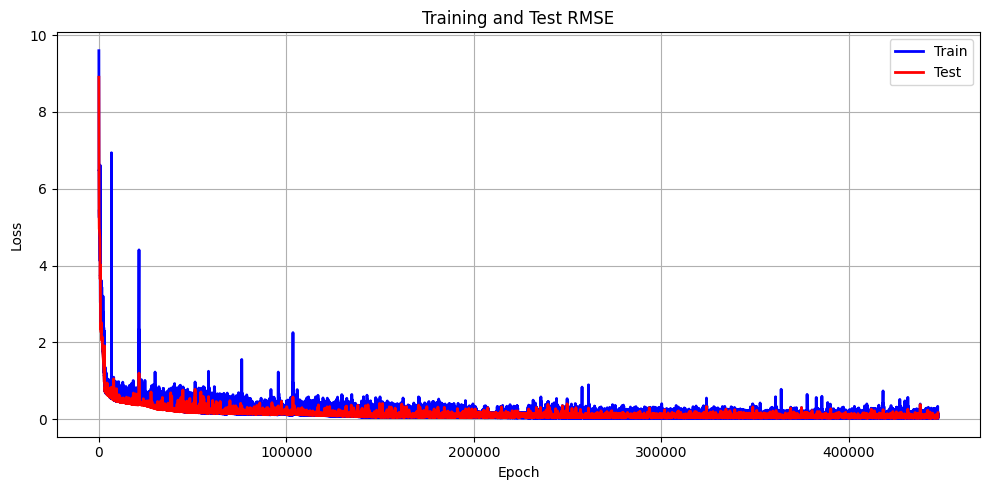

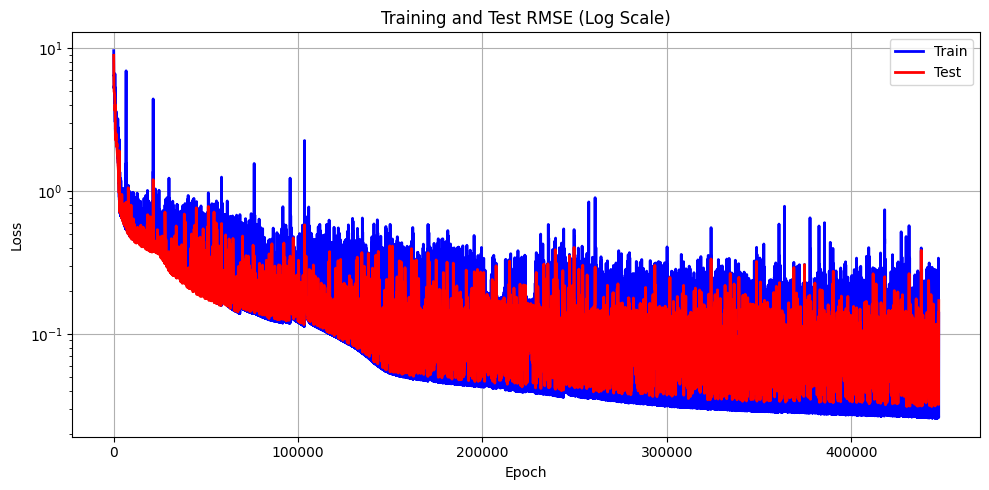

KeyboardInterrupt
Model saved to saves/models/3.model


In [ ]:
!/bin/mkdir saves/models/"{SESSION}"_snapshots/
if not is_saved:
    losses_train = []  # для хранения потерь на обучении
    losses_test = []
    writer = SummaryWriter(log_dir=tensorboard_dir)

    plot_interval = 50
    test_interval = 100
    snapshot_interval = 1000

    cnt_epochs = 1_000_000
    

    # Цикл обучения
    init_epoch = 0
    if len(listdir(f"saves/models/{SESSION}_snapshots/")) != 0:
        init_epoch = max(list(map(lambda x: int(x.split("."))[0], listdir(f"saves/{SESSION}_snapshots/")))) + 1
        model_market, model_derivative, optimizer, epoch, loss_train, loss_test = load_model(model_market, model_derivative, optimizer, f"models/{SESSION}_snapshots/{init_epoch - 1}.model")

    for epoch in tqdm(range(init_epoch, cnt_epochs)):
        try:
            model_market.train()
            model_derivative.train()
            
            optimizer.zero_grad()
            embedding_market = model_market(states_market_train)
            embedding_derivative = model_derivative(states_derivative_train)
            predictions_train = torch.sum(embedding_market * embedding_derivative, dim=1)
            
            loss_train = criterion(predictions_train, target_train)
            losses_train.append(loss_train.item() ** 0.5)
            writer.add_scalar("Loss/train", loss_train.item() ** 0.5, epoch)

            loss_train.backward()
            optimizer.step()

            # predict on test
            if epoch % test_interval == 0 or epoch == cnt_epochs - 1:
                model_market.eval()
                model_derivative.eval()

                with torch.no_grad():
                    embedding_market_test = model_market(states_market_test)
                    embedding_derivative_test = model_derivative(states_derivative_test)
                    predictions_test_epoch = torch.sum(embedding_market_test * embedding_derivative_test, dim=1)

                loss_test = criterion(predictions_test_epoch, target_test)
                losses_test.append(loss_test.item() ** 0.5)
                writer.add_scalar("Loss/test", loss_test.item() ** 0.5, epoch)

            # plotting
            if epoch % plot_interval == 0 or epoch == cnt_epochs - 1:
                clear_output(wait=True)
                
                # vanilla
                plt.figure(figsize=(10, 5))
                plt.plot(losses_train, label="Train", color='blue', linewidth=2)
                plt.plot(range(0, len(losses_test) * test_interval, test_interval), losses_test, label="Test", color='red', linewidth=2)
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.title("Training and Test RMSE")
                plt.grid()
                plt.legend()
                plt.tight_layout()
                plt.show()

                # log
                plt.figure(figsize=(10, 5))
                plt.plot(losses_train, label="Train", color='blue', linewidth=2)
                plt.plot(range(0, len(losses_test) * test_interval, test_interval), losses_test, label="Test", color='red', linewidth=2)
                plt.yscale('log')
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.title("Training and Test RMSE (Log Scale)")
                plt.grid()
                plt.legend()
                plt.tight_layout()
                plt.show()
            
            if epoch % snapshot_interval == 0:
                save_model(model_market, model_derivative, optimizer, epoch, loss_train, loss_test, filepath=f"saves/models/{SESSION}_snapshots/{epoch}.model")

        except KeyboardInterrupt:
            print("KeyboardInterrupt")
            break

    writer.close()
    save_model(model_market, model_derivative, optimizer, epoch, loss_train, loss_test, filepath=f"saves/models/{SESSION}.model")

In [ ]:
# clear_current_session()

# Scores

In [175]:
from sklearn.metrics import mean_absolute_error as mae, root_mean_squared_error as rmse, r2_score as r2

model_market.eval()
model_derivative.eval()
with torch.no_grad():
    embedding_market_train = model_market(states_market_train)
    embedding_derivative_train = model_derivative(states_derivative_train)
    prediction_train = torch.sum(embedding_market_train * embedding_derivative_train, dim=1)

    embedding_market_test = model_market(states_market_test)
    embedding_derivative_test = model_derivative(states_derivative_test)
    prediction_test = torch.sum(embedding_market_test * embedding_derivative_test, dim=1)

scores = pd.DataFrame({
    "metric": [
        "RMSE", 
        "R2", 
        "MAE"
    ],
    "Train": [
        rmse(target_train, prediction_train), 
        r2(target_train, prediction_train), 
        mae(target_train, prediction_train)
    ],
    "Test": [
        rmse(target_test, prediction_test), 
        r2(target_test, prediction_test), 
        mae(target_test, prediction_test)
    ]
})
scores = scores.set_index("metric")
scores.to_markdown(f"saves/scores/{SESSION}.md")
scores.to_pickle(f"saves/scores/{SESSION}.pckl")
scores

,Train,Test
metric,,
RMSE,0.056344,0.058222
R2,0.999919,0.999906
MAE,0.046998,0.046559


6.219042478003932

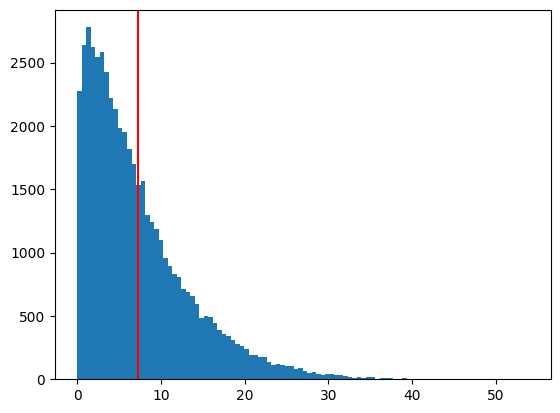

In [ ]:
plt.hist(target, bins=100)
plt.axvline(target.mean(), color='r')
rmse(target, np.full_like(target, target.mean()))